In [1]:
import csv
import math
from collections import defaultdict
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.gridspec as gridspec
import copy

### Mantis 10 Standard

In [2]:
base_folder = 'data/mantis_10/ModelInput_standard/'

In [3]:
def load_tsv_data(file_name: str):
    tsv_data = []
    with open(file_name, 'r') as f_in:
        reader = csv.reader(f_in, delimiter='\t')
        for index, row in enumerate(reader):
            tsv_data.append({'index': index, 'Q': row[1:-1], 'D': row[-1], 'L': int(row[0])})
    
    return tsv_data

In [4]:
def load_tsv_lookup(file_name: str):
    dataset_lookup = []
    with open(file_name, 'r') as f_lookup:
        content = f_lookup.readlines()
        dataset_lookup = [entry.replace('\n', '') for entry in content]
    
    return dataset_lookup

In [5]:
def load_corpus(base_folder):
    corpus_lookup = {}
    with open(base_folder + '/dmn_model_input/corpus.txt', 'r') as f_relations:
        content = f_relations.readlines()
        for entry in content:
            split_entry = entry.split('\t')
            corpus_lookup[split_entry[0]] = split_entry[1:]
    
    return corpus_lookup

In [6]:
def load_utterance_to_category_lookup(base_folder):
    allocations = ['train', 'dev', 'test']
    utterance_lookup = {}
    for allocation in allocations:
        json_dataset = {}
        with open(base_folder + 'merged_' + allocation + '.json', 'r') as f_dataset:
            json_dataset = json.load(f_dataset)
            
        for entry in json_dataset.values():
            for utterance in entry['utterances']:
                utterance_lookup[utterance['utterance'].replace('"', '')] = entry['category']
                
    return utterance_lookup

In [7]:
def load_confusion_lookup(base_folder):
    allocations = ['train', 'dev', 'test']
    confusion_lookup = {}
    for allocation in allocations:
        relations = []
        dataset_lookup = []
        with open(base_folder + 'data_' + allocation + '_easy_lookup.txt', 'r') as f_lookup:
            content = f_lookup.readlines()
            dataset_lookup = [entry.replace('\n', '') for entry in content]
            
        with open(base_folder + '/ModelInput_standard/dmn_model_input/relation_' + allocation + '.txt.fd', 'r') as f_relations:
            content = f_relations.readlines()
            for entry in content:
                split_entry = entry.split()
                relations.append({'Q': split_entry[1], 'D': split_entry[2], 'L': split_entry[0]})
        
        json_dataset = {}
        with open(base_folder + 'merged_' + allocation + '.json', 'r') as f_dataset:
            json_dataset = json.load(f_dataset)
            
        for index, entry in enumerate(relations):
            if entry['L'] == '1':
                doc = entry['D']
                dataset_index = dataset_lookup[index]
                category = json_dataset[str(dataset_index)]['category']
                confusion_lookup[doc] = category
                
    return confusion_lookup

In [8]:
def load_relations_lookup(base_folder, add_index_lookup: bool = False):
    tsv_data = []
    with open(base_folder + 'data_test_easy.tsv', 'r') as f_in:
        reader = csv.reader(f_in, delimiter='\t')
        for index, row in enumerate(reader):
            tsv_data.append({'Q': row[1:-1], 'D': row[-1], 'L': row[0], 'index': index})
            
    relations = []
    with open(base_folder + '/dmn_model_input/relation_test.txt.fd', 'r') as f_relations:
        content = f_relations.readlines()
        for entry in content:
            split_entry = entry.split()
            relations.append({'Q': split_entry[1], 'D': split_entry[2], 'L': split_entry[0]})
            
    relations_lookup = {}
    relations_lookup_index = {}
    for index, entry in enumerate(tsv_data):
        if entry['L'] == '1':
            relations_lookup[relations[index]['Q']] = entry['Q']
            relations_lookup[relations[index]['D']] = entry['D']
            relations_lookup_index[relations[index]['D']] = entry['index']
        
    return [relations_lookup, relations_lookup_index] if add_index_lookup else relations_lookup

In [9]:
def get_confusion_matrix_TREC(file_name):
    confusion_pairs = []
    with open(file_name, 'r') as f_results:
        content = f_results.readlines()
        confusion_pair = {'true': '', 'top_predicted': ''}
        for index, entry in enumerate(content):
            entry_split = entry.split('\t')
            label = int(entry_split[-1][:-1])
            rank = int(entry_split[3]) + 1
            if rank == 1:
                if confusion_pair['true'] != confusion_pair['top_predicted']:
                    confusion_pairs.append(copy.deepcopy(confusion_pair))
                
                confusion_pair['top_predicted'] = entry_split[2]
            if label == 1:
                confusion_pair['true'] = entry_split[2]
                
    return confusion_pairs

In [10]:
def read_TREC_file(file_name: str):
    predict_results = []
    with open(file_name, 'r') as f_results:
        content = f_results.readlines()
        for entry in content:
            entry_split = entry.split('\t')
            label = int(entry_split[-1][:-1])
            rank = int(entry_split[3]) + 1
            if label == 1:
                predict_results.append({'Q': entry_split[0], 'D': entry_split[2], 'rank': rank})
    return predict_results

In [11]:
def read_BERT_output(file_name: str):
    predict_results = []
    with open(file_name, 'r') as f_results:
        reader = csv.reader(f_results, delimiter='\t')
        current_context = []
        scores = []
        for index, score, label in reader:
            if int(index) > 0 and int(label) == 1:
                ranks = ss.rankdata(scores)
                predict_results += [{**entry, **{'rank': ranks[context_index]}} for context_index, entry in enumerate(current_context)]
                scores = []
                current_context = []
            current_context.append({'index': int(index), 'label': int(label), 'score': float(score)})
            scores.append(-float(score))
        
        if scores:
            ranks = ss.rankdata(scores)
            predict_results += [{**entry, **{'rank': ranks[context_index]}} for context_index, entry in enumerate(current_context)]

    return predict_results

In [12]:
def get_metrics_for_trec(results):
    aps = []
    ndcgs = []
    grouped_ranks = defaultdict(list)
    
    for entry in results:
        grouped_ranks[entry['Q']].append(entry['rank'])

    for ranks in grouped_ranks.values():
        ndcg_10 = sum([1 / math.log(rank + 1, 2) if rank <= 10 else 0 for rank in ranks])
        ideal_dcg = sum([1 / math.log(entry + 2, 2) if (entry + 2) <= 10 else 0 for entry in range(len(ranks))])
        ndcgs.append(ndcg_10 / ideal_dcg if ideal_dcg > 0 else 0)
        aps.append(sum([(index + 1) / rank for index, rank in enumerate(ranks)]) / len(ranks))
    
    map_val = sum(aps) / len(aps)
    ndcg_10 = sum(ndcgs) / len(ndcgs)
    
    return {
        'MAP': map_val,
        'NDCG@10': ndcg_10
    }

In [13]:
def get_metrics_for_ranks(ranks: list):
    mrr = (1 / len(ranks)) * sum([1/rank for rank in ranks])
    cg_10 = [1 / math.log(rank + 1, 2) if rank <= 10 else 0 for rank in ranks]
    ndcg_10 = (1 / len(ranks)) * sum(cg_10)
    
    return {
        'MAP': mrr,
        'NDCG@10': ndcg_10
    }

In [14]:
def load_first_utterance_to_category_lookup(base_folder):
    json_dataset = {}
    first_utterance_to_category_lookup = {}
    with open(base_folder + 'merged_test.json', 'r') as f_dataset:
        json_dataset = json.load(f_dataset)
        
    for entry in json_dataset.values():
        first_utterance_to_category_lookup[entry['utterances'][0]] = entry['category']
        
    return first_utterance_to_category_lookup

In [15]:
def load_indexes_per_category(base_folder, is_web=False):
    json_dataset = {}
    with open(base_folder + 'merged_test.json', 'r') as f_dataset:
        json_dataset = json.load(f_dataset)
        
    dataset_lookup = []
    file_name = 'data_test_easy_lookup.txt' if not is_web else 'data_test_web_lookup.txt'
    with open(base_folder + file_name, 'r') as f_lookup:
        content = f_lookup.readlines()
        dataset_lookup = [entry.replace('\n', '') for entry in content]
    
    index_per_categories = defaultdict(list)
    for index, conversation_index in enumerate(dataset_lookup):
        category = json_dataset[conversation_index]['category']
        index_per_categories[category].append(index)
            
    return index_per_categories

In [16]:
def load_category_lookup(base_folder):
    json_dataset = {}
    with open(base_folder + 'merged_test.json', 'r') as f_dataset:
        json_dataset = json.load(f_dataset)
        
    dataset_lookup = []
    with open(base_folder + 'data_test_easy_lookup.txt', 'r') as f_lookup:
        content = f_lookup.readlines()
        dataset_lookup = [entry.replace('\n', '') for entry in content]
        
    return [json_dataset[entry]['category'] for entry in dataset_lookup]

In [17]:
def load_category_occ_web(base_folder):
    category_occ = defaultdict(int)
    json_dataset = {}
    with open(base_folder + 'merged_test_urls.json', 'r') as f_dataset:
        json_dataset = json.load(f_dataset)
        
    url_mapping = {}
    with open(base_folder + 'url_mapping_test_filtered.json', 'r') as f_dataset:
        url_mapping = json.load(f_dataset)
        
    for entry in json_dataset.values():
        category = entry['category']
        urls = []
        for utt in entry['utterances']:
            urls += [url for url in utt['urls'] if url in url_mapping]
            
        category_occ[category] += len(urls)
    
    return category_occ

In [16]:
relations_lookup_standard = load_relations_lookup(base_folder)

In [122]:
results = read_TREC_file(base_folder + prefix + str(seed))
results_by_context_size = defaultdict(list)
for entry in results:
    context_size = len(relations_lookup_standard[entry['Q']])
    results_by_context_size[context_size].append(entry)

In [123]:
metrics_by_context_size = []
for context_size, entry in results_by_context_size.items():
    ranks = [result['rank'] for result in entry]
    mrr = (1 / len(ranks)) * sum([1/rank for rank in ranks])
    cg_10 = [1 / math.log(rank + 1, 2) if rank <= 10 else 0 for rank in ranks]
    ndcg_10 = (1 / len(ranks)) * sum(cg_10)
    metrics_by_context_size.append({'context_size': context_size, 'map': mrr, 'ndcg_10': ndcg_10})

### Intent Prediction Analysis

In [7]:
def interpret_intent_results(eval_results, multi_label=False):
    intent_results = defaultdict(list)
    for entry in eval_results:
        for label in entry['true']:
            intent_results[label].append(1 if label in entry['predicted'] else 0)
    
    return [{'intent': intent, 'precision': result.count(1) / len(result), 'model': 'BERT - MultiLabel' if multi_label else 'BERT'} for intent, result in intent_results.items()]

In [94]:
crossvals = list(range(10))
prefix = 'predict_outputs/intents/'
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load(prefix + 'encoder_classes.npy')
all_results_standard = []
mistakes_standard = defaultdict(int)
for crossval in crossvals:
    with open(prefix + 'eval_labels.tsv.' + str(crossval)) as f_eval:
        reader = csv.reader(f_eval, delimiter='\t')
        eval_results = [{
            'predicted': encoder.inverse_transform([int(row[1])])[0].split(','),
            'true': encoder.inverse_transform([int(row[2])])[0].split(',')
        } for row in reader]
        for entry in eval_results:
            true_labels = entry['true']
            predicted_labels = entry['predicted']
            true_labels.sort()
            predicted_labels.sort()
            if true_labels != predicted_labels:
                if 'PF' in true_labels:
                    mistakes_standard[','.join(true_labels) + '-' + ','.join(predicted_labels)] += 1
        all_results_standard += interpret_intent_results(eval_results)

### MultiLabel

In [95]:
base_folder = 'predict_outputs/intents/bert_eval_multilabel/'
encoder = MultiLabelBinarizer()
encoder.classes_ = np.load(base_folder + 'binarizer_encoder.npy')
all_results_multilabel = []
combinations = defaultdict(int)
mistakes_multilabel = defaultdict(int)
for iter in range(10):
    with open(base_folder + '/crossval_intents/eval_labels_multilabel.tsv.' + str(iter)) as f_in:
        reader = csv.reader(f_in, delimiter='\t')
        data = [row for row in reader]
        processed_data = [[[1.0 if float(entry) > 0 else 0.0 for entry in row[1][1:-1].split()], [float(entry) for entry in row[2][1:-1].split()]] 
                  for row in data]
        
        predicted_binary = np.array([row[0] for row in processed_data])
        predicted = encoder.inverse_transform(predicted_binary)
        predicted = [list(combination) for combination in predicted]

        true_binary = np.array([row[1] for row in processed_data])
        true = encoder.inverse_transform(true_binary)
        true = [list(combination) for combination in true]
        
        for index, true_labels in enumerate(true):
            true_labels.sort()
            predicted_labels = predicted[index]
            predicted_labels.sort()
            if true_labels != predicted_labels:
                if 'PF' in true_labels:
                    mistakes_multilabel[','.join(true_labels) + '-' + ','.join(predicted_labels)] += 1
        
        for combination in true:
            combination.sort()
            combinations[','.join(combination)] += 1
        eval_results = [{
            'predicted': predicted[index],
            'true': true_labels
        } for index, true_labels in enumerate(true)]
        all_results_multilabel += interpret_intent_results(eval_results, multi_label=True)

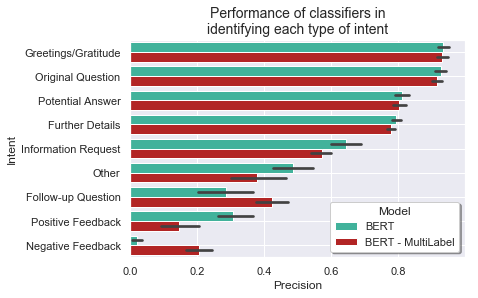

In [35]:
all_results_df = pd.DataFrame.from_records(all_results_standard + all_results_multilabel).sort_values(by=['precision'], ascending=False)
sns.set(style='darkgrid')
sns.set_palette(['#2ec5a6', '#c90d0d'])
sns.barplot(data=all_results_df, x='precision', y='intent', hue='model')
plt.title('Performance of classifiers in\nidentifying each type of intent', fontsize=14)
plt.xlabel('Precision', fontsize=12)
plt.yticks(np.arange(9), ('Greetings/Gratitude', 'Original Question', 'Potential Answer', 'Further Details',
                          'Information Request', 'Other', 'Follow-up Question', 'Positive Feedback', 
                          'Negative Feedback'))
plt.ylabel('Intent', fontsize=12)
plt.grid(True)
legend = plt.legend(loc='lower right', shadow=True, framealpha=1, title="Model")
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('multi_label_vs_single.pdf', dpi=300, bbox_inches='tight')

In [96]:

top_keys = sorted(mistakes_standard, key=mistakes_standard.get, reverse=True)[:10]
# print([{'intent': key , 'occ': mistakes_multilabel[key]} for key in top_keys])
total = sum(mistakes_standard.values())
print(total)
mistakes_standard_weighted = {key: (entry/total) * 100 for key, entry in mistakes_standard.items()}
top_keys = sorted(mistakes_standard_weighted, key=mistakes_standard_weighted.get, reverse=True)[:5]
top_mistakes_standard = [{'intent': key , 'percentage': mistakes_standard_weighted[key], 'model': 'BERT'} for key in top_keys]

296


In [97]:
top_keys = sorted(mistakes_multilabel, key=mistakes_multilabel.get, reverse=True)[:10]
# print([{'intent': key , 'occ': mistakes_multilabel[key]} for key in top_keys])
total = sum(mistakes_multilabel.values())
print(total)
mistakes_multilabel_weighted = {key: (entry/total) * 100 for key, entry in mistakes_multilabel.items()}
top_keys = sorted(mistakes_multilabel_weighted, key=mistakes_multilabel.get, reverse=True)[:5]
top_mistakes_multilabel = [{'intent': key , 'percentage': mistakes_multilabel_weighted[key], 'model': 'BERT - MultiLabel'} for key in top_keys]

346


### Interpret TREC results

##### MTL_WEB

In [22]:
seeds = [10, 100, 1000, 10000, 100000]
base_folder = 'predict_outputs/mantis_50/ModelInput_mtl_all/'
prefix = 'dmn_cnn_mtl_all.predict.test.txt-'
predict_results = []
for seed in seeds:
    results = read_TREC_file(base_folder + prefix + str(seed))
    aps = []
    ndcgs = []
    grouped_ranks = defaultdict(list)
    
    for entry in results:
        grouped_ranks[entry['Q']].append(entry['rank'])

    for ranks in grouped_ranks.values():
        ndcg_10 = sum([1.0 / math.log(rank + 1, 2) if rank <= 10 else 0 for rank in ranks])
        ideal_dcg = sum([1.0 / math.log(entry + 2, 2) if (entry + 2) <= 10 else 0 for entry in range(len(ranks))])
        ndcgs.append(ndcg_10 / ideal_dcg if ideal_dcg > 0 else 0)
        aps.append(sum([(index + 1) / rank for index, rank in enumerate(ranks)]) / len(ranks))
    
    map_val = sum(aps) / len(aps)
    ndcg_10 = sum(ndcgs) / len(ndcgs)
    
    predict_results.append({'MAP': map_val, 'NDCG@10': ndcg_10})
    

In [23]:
predict_results

[{'MAP': 0.5206600359499373, 'NDCG@10': 0.5959043878084289},
 {'MAP': 0.49510512524309114, 'NDCG@10': 0.5723375546174427},
 {'MAP': 0.5353482702357538, 'NDCG@10': 0.6104753600241974},
 {'MAP': 0.5343857179726472, 'NDCG@10': 0.6088728368690811},
 {'MAP': 0.5131420041797452, 'NDCG@10': 0.5910519331883662}]

#### Mantis_10

In [118]:
seeds = [10, 100, 1000, 10000, 100000]
base_folder = 'predict_outputs/mantis_10/ModelInput_standard/'
prefix = 'dmn_cnn.predict.test.txt-'
predict_results = []
for seed in seeds:
    results = read_TREC_file(base_folder + prefix + str(seed))
    ranks = [{'rank': entry['rank'], 'pos': e for entry in results]
    mrr = (1 / len(ranks)) * sum([1/rank for rank in ranks])
    cg_10 = [1 / math.log(rank + 1, 2) if rank <= 10 else 0 for rank in ranks]
    ndcg_10 = (1 / len(ranks)) * sum(cg_10)
    predict_results.append({'MAP': mrr, 'NDCG@10': ndcg_10})

### Compare context size performance - BERT vs DMN

#### Mantis_10

##### Load BERT data

In [88]:
base_folder = 'predict_outputs/mantis_10/BERT/standard/'
test_tsv_data = load_tsv_data(base_folder + 'test.tsv')
indexes_by_context_size = defaultdict(list)
for row in test_tsv_data:
    if (row['L'] == 1):
        context_size = len(row['Q'])
        indexes_by_context_size[context_size].append(row['index'])

seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

del test_tsv_data

bert_map_by_context_size = []
for context_size, indexes in indexes_by_context_size.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes]]))
        
    for entry in evals:
        bert_map_by_context_size.append({
            'context_size': context_size,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

#### Load DMN data

In [87]:
base_folder = 'predict_outputs/mantis_10/ModelInput_standard/'
relations_lookup_standard = load_relations_lookup(base_folder)
prefix = 'dmn_cnn.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_context_size = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_context_size = defaultdict(list)

    for entry in predict_results:
        context_size = len(relations_lookup_standard[entry['Q']])
        results_by_context_size[context_size].append(entry)
        
    for context_size, result in results_by_context_size.items():
        dmn_map_by_context_size.append({
            'context_size': context_size,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [89]:
# map_by_context_size
context_size_occ_df = pd.DataFrame.from_records([{'context_size': context_size, 'occurences': len(entries)} for context_size, entries in indexes_by_context_size.items()])
context_size_occ_df['occurences'] = (100. * context_size_occ_df['occurences'] / context_size_occ_df['occurences'].sum())
map_df_10 = pd.DataFrame.from_records(bert_map_by_context_size + dmn_map_by_context_size)


#### Mantis_50

##### Load BERT data

In [90]:
base_folder = 'predict_outputs/mantis_50/BERT/standard/'
test_tsv_data = load_tsv_data(base_folder + 'test.tsv')
indexes_by_context_size = defaultdict(list)
for row in test_tsv_data:
    if (row['L'] == 1):
        context_size = len(row['Q'])
        indexes_by_context_size[context_size].append(row['index'])

seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

del test_tsv_data
bert_map_by_context_size = []
for context_size, indexes in indexes_by_context_size.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes]]))
        
    for entry in evals:
        bert_map_by_context_size.append({
            'context_size': context_size,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })


##### Load DMN data

In [91]:
base_folder = 'predict_outputs/mantis_50/ModelInput_standard/'
relations_lookup_standard = load_relations_lookup(base_folder)
prefix = 'dmn_cnn.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_context_size = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_context_size = defaultdict(list)

    for entry in predict_results:
        context_size = len(relations_lookup_standard[entry['Q']])
        results_by_context_size[context_size].append(entry)
        
    for context_size, result in results_by_context_size.items():
        dmn_map_by_context_size.append({
            'context_size': context_size,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [92]:
# map_by_context_size
# context_size_occ_df = pd.DataFrame.from_records([{'context_size': context_size, 'occurences': len(entries)} for context_size, entries in indexes_by_context_size.items()])
# context_size_occ_df['occurences'] = (100. * context_size_occ_df['occurences'] / context_size_occ_df['occurences'].sum())
map_df_50 = pd.DataFrame.from_records(bert_map_by_context_size + dmn_map_by_context_size)


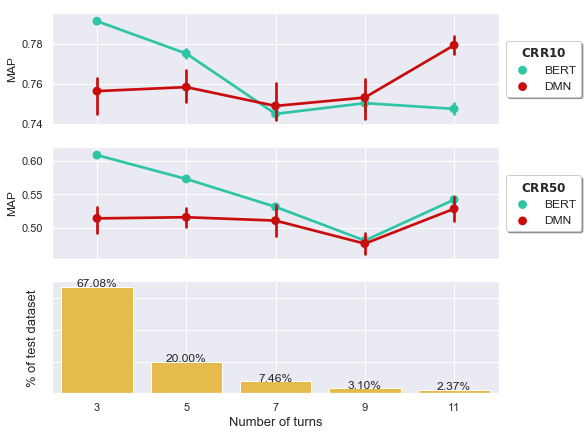

In [93]:
fig, ax = plt.subplots(3,1, figsize=(8,7))
# fig.suptitle("Performance of networks by number of turns \n (averaged over 5 runs)", fontsize=15)

sns.set(style='darkgrid')
sns.set_palette(['#2ec5a6', '#c90d0d'])

ax1 = sns.pointplot(data=map_df_10, y='MAP', x='context_size', hue='model', ax=ax[0], legend=False)
# ax1.get_xaxis().set_visible(False)
ax[0].xaxis.grid(True)
ax[0].get_xaxis().set_ticklabels([])
ax[0].set_xlabel('')

legend = ax1.legend(loc='upper center', shadow=True, framealpha=1, fontsize=12, title=r'$\bf{CRR10}$', bbox_to_anchor=(1.1, 0.8))
frame = legend.get_frame()
frame.set_facecolor('white')

ax2 = sns.pointplot(data=map_df_50, y='MAP', x='context_size', hue='model', ax=ax[1], legend=False)
# ax1.get_xaxis().set_visible(False)
ax[1].xaxis.grid(True)
ax[1].get_xaxis().set_ticklabels([])
ax[1].set_xlabel('')

legend = ax2.legend(loc='upper center', shadow=True, framealpha=1, fontsize=12, title=r'$\bf{CRR50}$', bbox_to_anchor=(1.1, 0.8))
frame = legend.get_frame()
frame.set_facecolor('white')

ax3 = sns.barplot(data=context_size_occ_df, x='context_size', y='occurences', ax=ax[2], color='#ffc631')
ax[2].get_yaxis().set_ticklabels([])
for p in ax3.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax3.annotate('{:.2%}'.format(height / 100), (p.get_x()+.5*width, p.get_y() + height + 0.01), ha = 'center')

plt.xlabel("Number of turns", fontsize=13)
plt.ylabel("% of test dataset", fontsize=13)
plt.grid(True)
# plt.savefig('Num_turns_performance_big_all.pdf', dpi=400, bbox_inches='tight')
# ax.set(xlabel='Number of turns', ylabel='MAP')

### Web

#### Mantis 10

#### BERT

In [112]:
base_folder = 'predict_outputs/mantis_10/BERT/web/'
test_tsv_data = load_tsv_data(base_folder + 'test.tsv')
indexes_by_context_size = defaultdict(list)
for row in test_tsv_data:
    if (row['L'] == 1):
        context_size = len(row['Q'])
        indexes_by_context_size[context_size].append(row['index'])

seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

del test_tsv_data

bert_map_by_context_size = []
for context_size, indexes in indexes_by_context_size.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes]]))
        
    for entry in evals:
        bert_map_by_context_size.append({
            'context_size': context_size,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

#### DMN

In [111]:
base_folder = 'predict_outputs/mantis_10/ModelInput_web/'
corpus = load_corpus(base_folder)
prefix = 'dmn_cnn_web.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_context_size = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_context_size = defaultdict(list)

    for entry in predict_results:
        context_size = len(corpus[entry['Q']])
        results_by_context_size[context_size].append(entry)
        
    for context_size, result in results_by_context_size.items():
        dmn_map_by_context_size.append({
            'context_size': context_size,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [113]:
context_size_occ_df = pd.DataFrame.from_records([{'context_size': context_size, 'occurences': len(entries)} for context_size, entries in indexes_by_context_size.items()])
context_size_occ_df['occurences'] = (100. * context_size_occ_df['occurences'] / context_size_occ_df['occurences'].sum())
map_df_web_10 = pd.DataFrame.from_records(bert_map_by_context_size + dmn_map_by_context_size)

#### Mantis 50

#### BERT

In [116]:
base_folder = 'predict_outputs/mantis_50/BERT/web/'
test_tsv_data = load_tsv_data(base_folder + 'test.tsv')
indexes_by_context_size = defaultdict(list)
for row in test_tsv_data:
    if (row['L'] == 1):
        context_size = len(row['Q'])
        indexes_by_context_size[context_size].append(row['index'])

seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

del test_tsv_data

bert_map_by_context_size = []
for context_size, indexes in indexes_by_context_size.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes]]))
        
    for entry in evals:
        bert_map_by_context_size.append({
            'context_size': context_size,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

In [117]:
base_folder = 'predict_outputs/mantis_50/ModelInput_web/'
corpus = load_corpus(base_folder)
prefix = 'dmn_cnn_web.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_context_size = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_context_size = defaultdict(list)

    for entry in predict_results:
        context_size = len(corpus[entry['Q']])
        results_by_context_size[context_size].append(entry)
        
    for context_size, result in results_by_context_size.items():
        dmn_map_by_context_size.append({
            'context_size': context_size,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [118]:
map_df_web_50 = pd.DataFrame.from_records(bert_map_by_context_size + dmn_map_by_context_size)

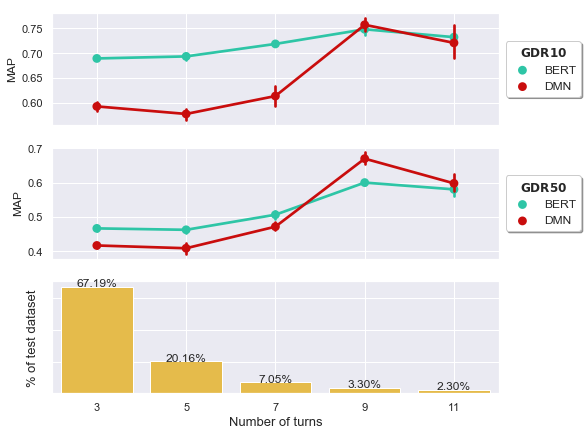

In [121]:
fig, ax = plt.subplots(3,1, figsize=(8,7))
# fig.suptitle("Performance of networks by number of turns \n (averaged over 5 runs)", fontsize=15)

sns.set(style='darkgrid')
sns.set_palette(['#2ec5a6', '#c90d0d'])

ax1 = sns.pointplot(data=map_df_web_10, y='MAP', x='context_size', hue='model', ax=ax[0], legend=False)
# ax1.get_xaxis().set_visible(False)
ax[0].xaxis.grid(True)
ax[0].get_xaxis().set_ticklabels([])
ax[0].set_xlabel('')

legend = ax1.legend(loc='upper center', shadow=True, framealpha=1, fontsize=12, title=r'$\bf{GDR10}$', bbox_to_anchor=(1.1, 0.8))
frame = legend.get_frame()
frame.set_facecolor('white')

ax2 = sns.pointplot(data=map_df_web_50, y='MAP', x='context_size', hue='model', ax=ax[1], legend=False)
# ax1.get_xaxis().set_visible(False)
ax[1].xaxis.grid(True)
ax[1].get_xaxis().set_ticklabels([])
ax[1].set_xlabel('')

legend = ax2.legend(loc='upper center', shadow=True, framealpha=1, fontsize=12, title=r'$\bf{GDR50}$', bbox_to_anchor=(1.1, 0.8))
frame = legend.get_frame()
frame.set_facecolor('white')

ax3 = sns.barplot(data=context_size_occ_df, x='context_size', y='occurences', ax=ax[2], color='#ffc631')
ax[2].get_yaxis().set_ticklabels([])
for p in ax3.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax3.annotate('{:.2%}'.format(height / 100), (p.get_x()+.5*width, p.get_y() + height + 0.01), ha = 'center')

plt.xlabel("Number of turns", fontsize=13)
plt.ylabel("% of test dataset", fontsize=13)
plt.grid(True)
plt.savefig('Num_turns_performance_web.pdf', dpi=400, bbox_inches='tight')
# ax.set(xlabel='Number of turns', ylabel='MAP')

### Compare performance by domain - BERT vs DMN

#### Mantis 10

#### Load BERT data

In [18]:
base_folder = 'predict_outputs/mantis_10/'
dataset_lookup = load_tsv_lookup(base_folder + 'data_test_easy_lookup.txt')
indexes_per_category = load_indexes_per_category(base_folder)

In [19]:
base_folder = 'predict_outputs/mantis_10/BERT/standard/'
seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

bert_map_by_category = []
for category, indexes in indexes_per_category.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes] if entry['label'] == 1]))
        
    for entry in evals:
        bert_map_by_category.append({
            'category': category,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

In [27]:
means_by_all_category = defaultdict(list)
for entry in bert_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.04146135524270681


#### Load DMN data

In [29]:
base_folder = 'predict_outputs/mantis_10/'
category_lookup = load_category_lookup(base_folder)

base_folder = 'predict_outputs/mantis_10/ModelInput_standard/'
relations_lookup_standard, relations_lookup_indexes = load_relations_lookup(base_folder, add_index_lookup = True)

prefix = 'dmn_cnn.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_category = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    ranks_by_category = defaultdict(list)

    for entry in predict_results:
        category_index = relations_lookup_indexes[entry['D']]
        category = category_lookup[category_index]
        ranks_by_category[category].append(entry['rank'])
        
    for category, ranks in ranks_by_category.items():
        dmn_map_by_category.append({
            'category': category,
            'MAP': get_metrics_for_ranks(ranks)['MAP'],
            'model': 'DMN'
        })

In [30]:
means_by_all_category = defaultdict(list)
for entry in dmn_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.0399516063868153


In [18]:
category_occurences = defaultdict(int)
for entry in category_lookup:
    category_occurences[entry] += 1

category_occ = [{'category': category, 'occurences': occurences} for category, occurences in category_occurences.items()]

In [19]:
category_map_df_10 = pd.DataFrame.from_records(bert_map_by_category + dmn_map_by_category)
category_occ_df = pd.DataFrame.from_records(category_occ)
category_occ_df['occurences'] = (100. * category_occ_df['occurences'] / category_occ_df['occurences'].sum())

#### Mantis_50

In [31]:
base_folder = 'predict_outputs/mantis_50/'
dataset_lookup = load_tsv_lookup(base_folder + 'data_test_easy_lookup.txt')
indexes_per_category = load_indexes_per_category(base_folder)

#### BERT

In [32]:
base_folder = 'predict_outputs/mantis_50/BERT/standard/'
seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

bert_map_by_category = []
for category, indexes in indexes_per_category.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes] if entry['label'] == 1]))
        
    for entry in evals:
        bert_map_by_category.append({
            'category': category,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

In [33]:
means_by_all_category = defaultdict(list)
for entry in bert_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.0788616923659863


#### DMN

In [34]:
base_folder = 'predict_outputs/mantis_50/'
category_lookup = load_category_lookup(base_folder)

base_folder = 'predict_outputs/mantis_50/ModelInput_standard/'
relations_lookup_standard, relations_lookup_indexes = load_relations_lookup(base_folder, add_index_lookup = True)

prefix = 'dmn_cnn.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_category = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_category = defaultdict(list)

    for entry in predict_results:
        category_index = relations_lookup_indexes[entry['D']]
        category = category_lookup[category_index]
        results_by_category[category].append(entry)
        
    for category, result in results_by_category.items():
        dmn_map_by_category.append({
            'category': category,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [35]:
means_by_all_category = defaultdict(list)
for entry in dmn_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.049753761982770255


In [23]:
# category_occurences = defaultdict(int)
# for entry in category_lookup:
#     category_occurences[entry] += 1

# category_occ = [{'category': category, 'occurences': occurences} for category, occurences in category_occurences.items()]

category_map_df_50 = pd.DataFrame.from_records(bert_map_by_category + dmn_map_by_category)
# category_occ_df = pd.DataFrame.from_records(category_occ)
# category_occ_df['occurences'] = (100. * category_occ_df['occurences'] / category_occ_df['occurences'].sum())

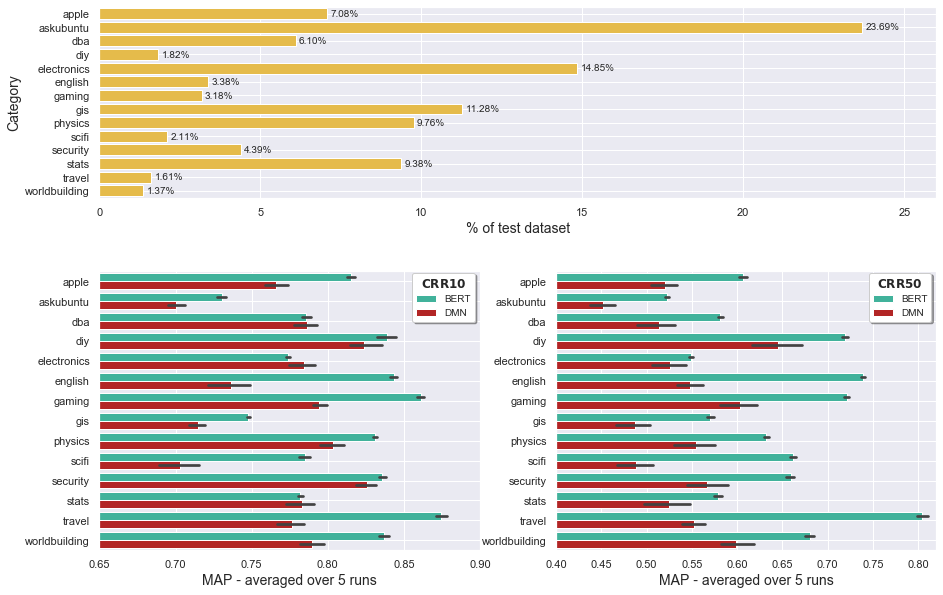

In [95]:
# fig.suptitle("Performance of networks by category", fontsize=20)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(7, 4, figure=fig)
gs.update(wspace=0.5, hspace=5)
ax1 = plt.subplot(gs[0:3, 0:4])
ax2 = plt.subplot(gs[3:7, 0:2])
ax3 = plt.subplot(gs[3:7, 2:4])


sns.set(style='darkgrid')
sns.set_palette(['#2ec5a6', '#c90d0d'])

# plt.set_figwidth(14)
# fig.set_figheight(17)
# fig = plt.figure(figsize=(15, 5))
# ax = plt.subplot2grid((1, 1), (0, 0), colspan=2, rowspan=2)

ax1 = sns.barplot(data=category_occ_df, y='category', x='occurences', ax=ax1, color='#ffc631')
ax1.set_xlabel('% of test dataset', fontsize=14)
ax1.set_ylabel('Category', fontsize=14)
ax1.grid(True)
ax1.set_xlim([0, 26])


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate('{:.2%}'.format(width / 100), (p.get_x() + width + 0.1, p.get_y() + .75 * height), fontsize=10)


ax2 = sns.barplot(data=category_map_df_10, x='MAP', y='category', hue='model', ax=ax2)

ax2.set_ylabel('')
ax2.set_xlabel('MAP - averaged over 5 runs', fontsize=14)
ax2.set_xlim([0.65, 0.9])
ax2.grid(True)

legend = ax2.legend(loc='upper right', shadow=True, framealpha=1, bbox_to_anchor=(1, 1.012), fontsize=10, title=r'$\bf{CRR10}$')
frame = legend.get_frame()
frame.set_facecolor('white')

ax3 = sns.barplot(data=category_map_df_50, x='MAP', y='category', hue='model', ax=ax3)

ax3.set_ylabel('')
ax3.set_xlabel('MAP - averaged over 5 runs', fontsize=14)
ax3.set_xlim([0.4, 0.82])
ax3.grid(True)
# ax[1].yaxis.tick_right()
# plt.grid(True)

legend = ax3.legend(loc='upper right', shadow=True, framealpha=1, bbox_to_anchor=(1, 1.012), fontsize=10, title=r'$\bf{CRR50}$')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('category_performance_all.pdf', dpi=400, bbox_inches='tight')

#### Confusion Matrix    

In [31]:
base_folder = 'predict_outputs/mantis_50/'
confusion_lookup = load_confusion_lookup(base_folder)
base_folder = 'predict_outputs/mantis_50/ModelInput_standard/'
prefix = 'dmn_cnn.predict.test.txt-'
confusion_matrix_raw = get_confusion_matrix_TREC(base_folder + prefix + '10')
cat_true = []
cat_predicted = []
for entry in confusion_matrix_raw:
    if entry['true'] in confusion_lookup and entry['top_predicted'] in confusion_lookup:
        category_true = confusion_lookup[entry['true']]
        category_top_predicted = confusion_lookup[entry['top_predicted']]
        if category_true != category_top_predicted:
            cat_true.append(category_true)
            cat_predicted.append(category_top_predicted)

# del relations_lookup_standard
# del relations_lookup_indexes
# del category_lookup

In [42]:
rows = sorted(np.unique(cat_true))
columns = sorted(np.unique(cat_true))
conf_matrix = np.zeros((len(rows), len(columns)))
for index, true_label in enumerate(cat_true):
    predicted_label = cat_predicted[index]
    conf_matrix[rows.index(true_label)][columns.index(predicted_label)] += 1
#     conf_matrix[rows.index(predicted_label)][columns.index(true_label)] += 1

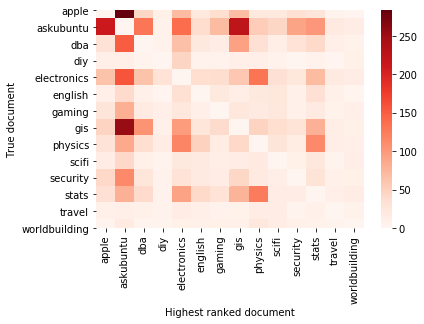

In [45]:
df_cm = pd.DataFrame(conf_matrix, index = rows, columns = columns)
sns.heatmap(df_cm, cmap="Reds")
plt.xlabel('Highest ranked document')
plt.ylabel('True document')
plt.savefig('confusion_mantis_50.pdf', dpi=400, bbox_inches='tight')

#### Web

#### BERT

In [36]:
base_folder = 'predict_outputs/mantis_10/'
dataset_lookup = load_tsv_lookup(base_folder + 'data_test_web_lookup.txt')
indexes_per_category = load_indexes_per_category(base_folder, is_web=True)

base_folder = 'predict_outputs/mantis_10/BERT/web/'
seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

bert_map_by_category = []
for category, indexes in indexes_per_category.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes] if entry['label'] == 1]))
        
    for entry in evals:
        bert_map_by_category.append({
            'category': category,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

In [37]:
means_by_all_category = defaultdict(list)
for entry in bert_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.07864676002375823


#### DMN

In [38]:
base_folder = 'predict_outputs/mantis_10/ModelInput_web/'
corpus = load_corpus(base_folder)

base_folder = 'predict_outputs/mantis_10/'
utterance_to_category_lookup = load_utterance_to_category_lookup(base_folder)

base_folder = 'predict_outputs/mantis_10/ModelInput_web/'
prefix = 'dmn_cnn_web.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_category = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_category = defaultdict(list)

    for entry in predict_results:
        utterance = corpus[entry['Q']][0].replace('"', '')
        category = utterance_to_category_lookup[utterance]
        results_by_category[category].append(entry)
        
    for category, result in results_by_category.items():
        dmn_map_by_category.append({
            'category': category,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [39]:
means_by_all_category = defaultdict(list)
for entry in dmn_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.0725541302144898


In [80]:
base_folder = 'predict_outputs/mantis_10/'
categories_occ_web = load_category_occ_web(base_folder)
category_occ = [{'category': category, 'occurences': occurences} for category, occurences in categories_occ_web.items()]
category_occ_df = pd.DataFrame.from_records(category_occ)
category_occ_df['occurences'] = (100. * category_occ_df['occurences'] / category_occ_df['occurences'].sum())
category_map_df_10 = pd.DataFrame.from_records(bert_map_by_category + dmn_map_by_category)
# sns.barplot(data=category_map_df_10, x='MAP', y='category', hue='model')

#### Mantis 50

#### BERT

In [40]:
base_folder = 'predict_outputs/mantis_50/'
dataset_lookup = load_tsv_lookup(base_folder + 'data_test_web_lookup.txt')
indexes_per_category = load_indexes_per_category(base_folder, is_web=True)

base_folder = 'predict_outputs/mantis_50/BERT/web/'
seeds = [10, 100, 1000, 10000, 100000]
file_name = base_folder + 'eval_labels-'
bert_eval_data = {}
for seed in seeds:
    bert_eval_data[seed] = read_BERT_output(file_name + str(seed) + '.tsv')

bert_map_by_category = []
for category, indexes in indexes_per_category.items():
    evals = []
    for eval_data in bert_eval_data.values():
        evals.append(get_metrics_for_ranks([entry['rank'] for entry in np.array(eval_data)[indexes] if entry['label'] == 1]))
        
    for entry in evals:
        bert_map_by_category.append({
            'category': category,
            'MAP': entry['MAP'],
            'model': 'BERT'
        })

In [42]:
means_by_all_category = defaultdict(list)
for entry in bert_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.10526204250941734


In [43]:
base_folder = 'predict_outputs/mantis_50/ModelInput_web/'
corpus = load_corpus(base_folder)

base_folder = 'predict_outputs/mantis_10/'
utterance_to_category_lookup = load_utterance_to_category_lookup(base_folder)

base_folder = 'predict_outputs/mantis_50/ModelInput_web/'
prefix = 'dmn_cnn_web.predict.test.txt-'
seeds = [10, 100, 1000, 10000, 100000]
dmn_map_by_category = []
for seed in seeds:
    predict_results = read_TREC_file(base_folder + prefix + str(seed))
    results_by_category = defaultdict(list)

    for entry in predict_results:
        utterance = corpus[entry['Q']][0].replace('"', '')
        category = utterance_to_category_lookup[utterance]
        results_by_category[category].append(entry)
        
    for category, result in results_by_category.items():
        dmn_map_by_category.append({
            'category': category,
            'MAP': get_metrics_for_trec(result)['MAP'],
            'model': 'DMN'
        })

In [44]:
means_by_all_category = defaultdict(list)
for entry in dmn_map_by_category:
    category = entry['category']
    map_val = entry['MAP']
    means_by_all_category[category].append(map_val)

means = []
for entry in means_by_all_category.values():
    means.append(np.mean(entry))
    
print(np.std(means))

0.0633614741786789


In [75]:
category_map_df_50 = pd.DataFrame.from_records(bert_map_by_category + dmn_map_by_category)
# sns.barplot(data=category_map_df_10, x='MAP', y='category', hue='model')

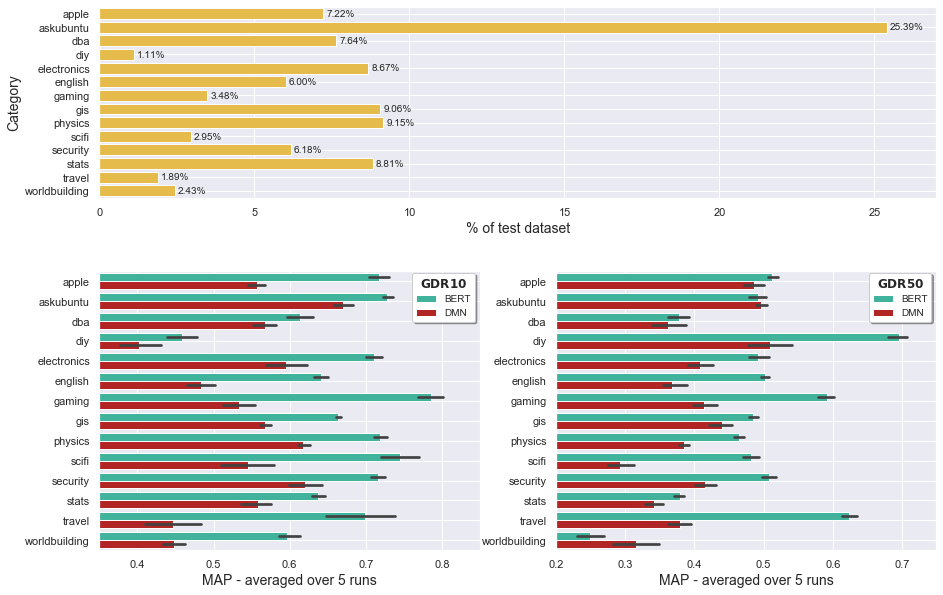

In [89]:
# fig.suptitle("Performance of networks by category", fontsize=20)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(7, 4, figure=fig)
gs.update(wspace=0.5, hspace=5)
ax1 = plt.subplot(gs[0:3, 0:4])
ax2 = plt.subplot(gs[3:7, 0:2])
ax3 = plt.subplot(gs[3:7, 2:4])


sns.set(style='darkgrid')
sns.set_palette(['#2ec5a6', '#c90d0d'])

# plt.set_figwidth(14)
# fig.set_figheight(17)
# fig = plt.figure(figsize=(15, 5))
# ax = plt.subplot2grid((1, 1), (0, 0), colspan=2, rowspan=2)

ax1 = sns.barplot(data=category_occ_df, y='category', x='occurences', ax=ax1, color='#ffc631')
ax1.set_xlabel('% of test dataset', fontsize=14)
ax1.set_ylabel('Category', fontsize=14)
ax1.grid(True)
ax1.set_xlim([0, 27])


for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax1.annotate('{:.2%}'.format(width / 100), (p.get_x() + width + 0.1, p.get_y() + .75 * height), fontsize=10)


ax2 = sns.barplot(data=category_map_df_10, x='MAP', y='category', hue='model', ax=ax2)

ax2.set_ylabel('')
ax2.set_xlabel('MAP - averaged over 5 runs', fontsize=14)
ax2.set_xlim([0.35, 0.85])
ax2.grid(True)

legend = ax2.legend(loc='upper right', shadow=True, framealpha=1, bbox_to_anchor=(1, 1.012), fontsize=10, title=r'$\bf{GDR10}$')
frame = legend.get_frame()
frame.set_facecolor('white')

ax3 = sns.barplot(data=category_map_df_50, x='MAP', y='category', hue='model', ax=ax3)

ax3.set_ylabel('')
ax3.set_xlabel('MAP - averaged over 5 runs', fontsize=14)
ax3.set_xlim([0.2, 0.75])
ax3.grid(True)
# ax[1].yaxis.tick_right()
# plt.grid(True)

legend = ax3.legend(loc='upper right', shadow=True, framealpha=1, bbox_to_anchor=(1, 1.012), fontsize=10, title=r'$\bf{GDR50}$')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('category_performance_web_all.pdf', dpi=400, bbox_inches='tight')

#### DMN

### MTL Analysis

#### Mantis_10

### Web

In [24]:
base_folder = 'predict_outputs/mantis_10/'
with open(base_folder + 'mtl_web_web_eval.json') as f:
    mtl_web_web_data = json.load(f)
with open(base_folder + 'web_eval.json') as f:
    web_data = json.load(f)
with open(base_folder + 'mtl_web_intents_eval.json') as f:
    mtl_web_intents_data = json.load(f)
with open(base_folder + 'mtl_all_web_eval.json') as f:
    mtl_all_web_data = json.load(f)

#### Mantis_50

In [25]:
base_folder = 'predict_outputs/mantis_50/'
with open(base_folder + 'mtl_web_web_eval.json') as f:
    mtl_web_web_data_50 = json.load(f)
with open(base_folder + 'web_eval.json') as f:
    web_data_50 = json.load(f)
with open(base_folder + 'mtl_web_intents_eval.json') as f:
    mtl_web_intents_data_50 = json.load(f)
with open(base_folder + 'mtl_all_web_eval.json') as f:
    mtl_all_web_data_50 = json.load(f)

#### CRR

#### Mantis_10

In [26]:
base_folder = 'predict_outputs/mantis_10/'
with open(base_folder + 'mtl_web_eval.json') as f:
    mtl_web_data = json.load(f)
with open(base_folder + 'mtl_intents_eval.json') as f:
    standard_intents = json.load(f)
with open(base_folder + 'standard_eval.json') as f:
    standard_data = json.load(f)
with open(base_folder + 'mtl_all_eval.json') as f:
    mtl_all_data = json.load(f)

#### Mantis_50

In [27]:
base_folder = 'predict_outputs/mantis_50/'
with open(base_folder + 'mtl_web_eval.json') as f:
    mtl_web_data_50 = json.load(f)
with open(base_folder + 'mtl_intents_eval.json') as f:
    standard_intents_50 = json.load(f)
with open(base_folder + 'standard_eval.json') as f:
    standard_data_50 = json.load(f)
with open(base_folder + 'mtl_all_eval.json') as f:
    mtl_all_data_50 = json.load(f)

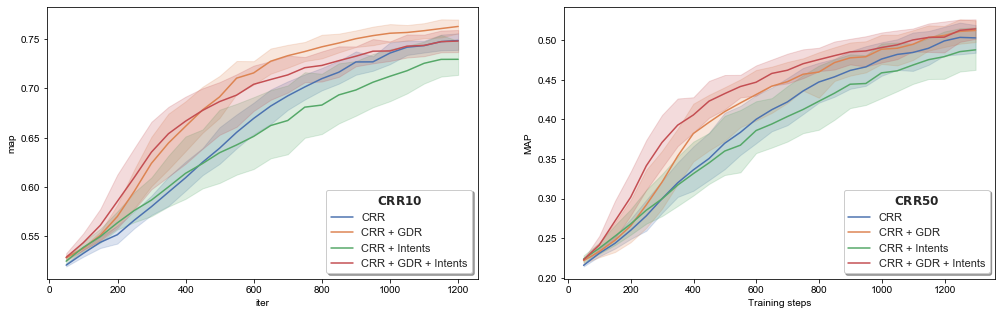

In [28]:
standard_df = pd.DataFrame.from_records(standard_data + mtl_web_data + standard_intents + mtl_all_data)
standard_df_50 = pd.DataFrame.from_records(standard_data_50 + mtl_web_data_50 + standard_intents_50 + mtl_all_data_50)

fig, ax = plt.subplots(1,2, figsize=(17,5))
sns.set(style='darkgrid')

plot = sns.lineplot(data = standard_df, x='iter', y='map', hue='model', ax = ax[0])
handles, labels = plot.get_legend_handles_labels()
legend = plot.legend(handles=handles[1:], labels=labels[1:], loc='lower right', shadow=True, framealpha=1, title=r'$\bf{CRR10}$')
frame = legend.get_frame()
frame.set_facecolor('white')

plot_50 = sns.lineplot(data = standard_df_50, x='iter', y='map', hue='model', ax = ax[1])
handles, labels = plot_50.get_legend_handles_labels()
legend = plot_50.legend(handles=handles[1:], labels=labels[1:], loc='lower right', shadow=True, framealpha=1, title=r'$\bf{CRR50}$')
frame = legend.get_frame()
frame.set_facecolor('white')


plt.xlabel('Training steps')
plt.ylabel('MAP')
plt.savefig('learning_curve_mtl_crr.pdf', dpi=400, bbox_inches='tight')

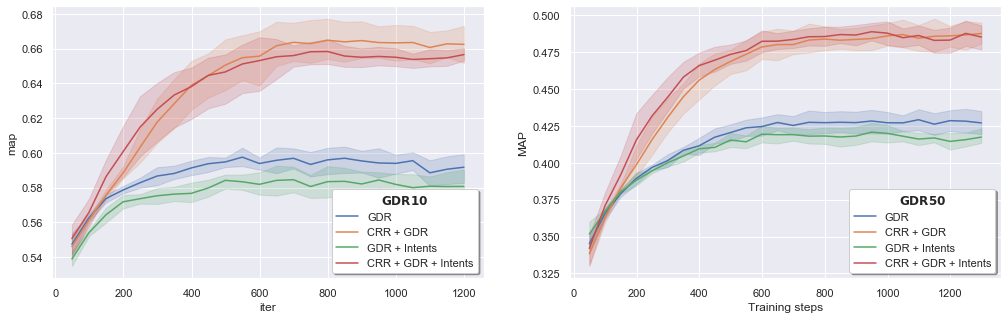

In [29]:
web_df = pd.DataFrame.from_records(web_data + mtl_web_web_data + mtl_web_intents_data + mtl_all_web_data)
web_df_50 = pd.DataFrame.from_records(web_data_50 + mtl_web_web_data_50 + mtl_web_intents_data_50 + mtl_all_web_data_50)
fig, ax = plt.subplots(1,2, figsize=(17,5))
sns.set(style='darkgrid')

plot = sns.lineplot(data = web_df, x='iter', y='map', hue='model', ax = ax[0])
handles, labels = plot.get_legend_handles_labels()
legend = plot.legend(handles=handles[1:], labels=labels[1:], loc='lower right', shadow=True, framealpha=1, title=r'$\bf{GDR10}$')
frame = legend.get_frame()
frame.set_facecolor('white')

plot_50 = sns.lineplot(data = web_df_50, x='iter', y='map', hue='model', ax = ax[1])
handles, labels = plot_50.get_legend_handles_labels()
legend = plot_50.legend(handles=handles[1:], labels=labels[1:], loc='lower right', shadow=True, framealpha=1, title=r'$\bf{GDR50}$')
frame = legend.get_frame()
frame.set_facecolor('white')


plt.xlabel('Training steps')
plt.ylabel('MAP')
plt.savefig('learning_curve_mtl_gdr.pdf', dpi=400, bbox_inches='tight')